<a href="https://colab.research.google.com/github/yashc73080/CS462-Deep-Learning/blob/main/HW1/architecture_and_hyperparam_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt

Set the random seed

In [16]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Generating and Preparing Data

In [17]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [18]:
def preprocess_data(dataset, device):
  data = (dataset.data / 255.0) - 0.5
  flattened_data = data.view(data.size(0), -1)
  targets = dataset.targets
  return flattened_data.to(device), targets.to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train, y_train = preprocess_data(trainset, device)
X_test, y_test = preprocess_data(testset, device)

In [38]:
X_train.size()

torch.Size([60000, 784])

Due to redundancy in all network classes, create a BaseNetwork class which will be inherited by the other networks

In [20]:
class BaseNetwork(nn.Module):
  def __init__(self, device='cpu'):
    super().__init__()
    self.device = torch.device('cuda' if torch.cuda.is_available() else device)

  def forward(self, x):
    pass

  def train(self, X_train, y_train, epochs=25, lr=0.1, batch_size=64, verbose=True):
    self.loss_function = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.parameters(), lr=lr)

    n = X_train.size(0)
    final_train_loss = 0.0

    for epoch in range(epochs):
      total_loss = 0.0

      for i in range(0, n, batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        logits = self.forward(x_batch)
        loss = self.loss_function(logits, y_batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        total_loss += loss.item()

      final_train_loss = total_loss / (n // batch_size)
      if verbose:
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {final_train_loss:.4f}")

    with torch.no_grad():
      logits = self.forward(X_train)
      preds = torch.argmax(logits, dim=1)
      acc = (preds == y_train).float().mean().item()
    if verbose:
      print(f"Final Train Loss: {final_train_loss:.4f}, Final Train Accuracy: {acc:.4f}")
    return final_train_loss

  def test(self, X_test, y_test, verbose=True):
    with torch.no_grad():
      logits = self.forward(X_test)
      loss = self.loss_function(logits, y_test)
      preds = torch.argmax(logits, dim=1)
      acc = (preds == y_test).float().mean().item()
    if verbose:
      print(f"Test Loss: {loss.item():.4f}, Test Accuracy: {acc:.4f}")
    return loss.item(), acc

# 1. Basic Model

$F(\vec{x}) = \text{softmax}(A\vec{v}+\vec{b})$

In [31]:
class BasicModel(BaseNetwork):
  def __init__(self, input_size=784, output_size=10, device='cpu'):
    super().__init__(device=device)
    # Model parameters
    self.A = nn.Parameter(torch.randn(output_size, input_size, device=self.device), requires_grad=True) # shape (10, 784)
    self.b = nn.Parameter(torch.randn(output_size, device=self.device), requires_grad=True)  # shape (10,)

    self.to(self.device)

  def forward(self, x):
    logits = x @ self.A.t() + self.b # CrossEntropyLoss applies softmax internally
    return logits

  # train() and test() are inherited from BaseNetwork

In [24]:
basic_model = BasicModel(input_size=784, output_size=10)
basic_model.train(X_train, y_train, epochs=350, lr=0.05, batch_size=64)
basic_test_loss, basic_test_acc = basic_model.test(X_test, y_test)

Epoch 1/350, Training Loss: 3.2811
Epoch 2/350, Training Loss: 1.2002
Epoch 3/350, Training Loss: 0.9431
Epoch 4/350, Training Loss: 0.8180
Epoch 5/350, Training Loss: 0.7411
Epoch 6/350, Training Loss: 0.6877
Epoch 7/350, Training Loss: 0.6480
Epoch 8/350, Training Loss: 0.6167
Epoch 9/350, Training Loss: 0.5913
Epoch 10/350, Training Loss: 0.5700
Epoch 11/350, Training Loss: 0.5518
Epoch 12/350, Training Loss: 0.5359
Epoch 13/350, Training Loss: 0.5219
Epoch 14/350, Training Loss: 0.5094
Epoch 15/350, Training Loss: 0.4982
Epoch 16/350, Training Loss: 0.4880
Epoch 17/350, Training Loss: 0.4787
Epoch 18/350, Training Loss: 0.4701
Epoch 19/350, Training Loss: 0.4622
Epoch 20/350, Training Loss: 0.4549
Epoch 21/350, Training Loss: 0.4481
Epoch 22/350, Training Loss: 0.4418
Epoch 23/350, Training Loss: 0.4358
Epoch 24/350, Training Loss: 0.4302
Epoch 25/350, Training Loss: 0.4250
Epoch 26/350, Training Loss: 0.4200
Epoch 27/350, Training Loss: 0.4153
Epoch 28/350, Training Loss: 0.4108
E

# 2. Fixed Size Layer Model

$\text{Parameters}(k,m)$ in terms of input size $n_{in}$, output size $n_{out}$, number of hidden layers $k$, and number of nodes per hidden layer $m$.

The following formula is the number of trainable parameters in the network. The full logic is in the report.
$$\text{Parameters}(k,m) = [(n_{in} \cdot m) + m] + [(k-1) \cdot (m \cdot m + m)] + [(m \cdot n_{out}) + n_{out}]$$

In [30]:
class FixedSizeNetwork(BaseNetwork):
  def __init__(self, input_size=784, output_size=10, num_layers=2, hidden_width=200, device='cpu'):
    '''
    Args:
      input_size (int): MNIST input size
      output_size (int): MNIST output size
      num_layers (int): Number of hidden layers (k)
      hidden_width (int): Width of hidden layers (m)
    '''
    super().__init__(device=device)

    # All layers of network
    layers = []

    # First layer (Input -> H1)
    layers.append(nn.Linear(input_size, hidden_width))
    layers.append(nn.Tanh())

    # Rest of the layers
    for _ in range(num_layers - 1):
      layers.append(nn.Linear(hidden_width, hidden_width))
      layers.append(nn.Tanh())

    # Wrap hidden layers
    self.hidden_layers = nn.Sequential(*layers)

    # Add output layer (Hk -> Output)
    self.output_layer = nn.Linear(hidden_width, output_size)

    # Move whole network to device
    self.to(self.device)

  def forward(self, x):
    # Flatten input
    x = x.view(x.size(0), -1)

    # Pass input through all hidden layers
    x = self.hidden_layers(x)

    # Pass through output layer
    logits = self.output_layer(x)

    return logits

  # train() and test() are inherited from BaseNetwork

Find the best combination of k and m

In [13]:
def num_parameters(input_size=784, output_size=10, k=2, m=200):
    '''
    k = number of hidden layers
    m = width of hidden layers (number of nodes per hidden layer)
    '''
    input_H1 = (input_size * m) + m
    all_H = (k - 1) * (m * m + m)
    lastH_output = (m * output_size) + output_size
    return input_H1 + all_H + lastH_output

def get_m_for_k(k, P, n_in=784, n_out=10):
    if k == 1:
        # Simplified formula for k=1: P = (n_in + n_out)m + m + n_out
        # P = 794m + m + 10 = 795m + 10
        m = (P - n_out) / (n_in + 1 + n_out)
        return round(m)
    else:
        # Quadratic formula: am^2 + bm + c = 0
        a = k - 1
        b = k + n_in + n_out
        c = n_out - P

        # Calculate the discriminant
        discriminant = b**2 - 4*a*c

        if discriminant < 0:
            return None # No real solution for m

        # Solve for m (we only care about the positive root)
        m = (-b + np.sqrt(discriminant)) / (2 * a)
        return round(m)


In [16]:
P_values = [100000, 250000, 500000]
k_to_test = [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]

all_results = {}

# Loop through each budget
for P in P_values:
    print(f"--- Starting Experiment for P = {P} ---")

    # Store results for this specific P
    current_p_results = {'k': [], 'train_loss': [], 'test_loss': []}

    # Loop through each k value to test
    for k in k_to_test:
        # 4. Use helper functions to get the network width
        m = get_m_for_k(k, P)

        # Check if m is a valid width
        if m is None or m < 1:
            continue

        print(f"Testing shape: k={k}, m={m}")

        # Build and train network
        model = FixedSizeNetwork(num_layers=k, hidden_width=m, device=device)
        final_train_loss = model.train(X_train, y_train, lr=0.1, epochs=25, verbose=False)
        final_test_loss, _ = model.test(X_test, y_test, verbose=False)

        # Save the results
        current_p_results['k'].append(k)
        current_p_results['train_loss'].append(final_train_loss)
        current_p_results['test_loss'].append(final_test_loss)


    all_results[P] = current_p_results

--- Starting Experiment for P = 100000 ---
Testing shape: k=1, m=126
Testing shape: k=2, m=110
Testing shape: k=4, m=93
Testing shape: k=6, m=82
Testing shape: k=8, m=75
Testing shape: k=10, m=70
Testing shape: k=15, m=60
Testing shape: k=20, m=54
Testing shape: k=30, m=46
Testing shape: k=50, m=37
--- Starting Experiment for P = 250000 ---
Testing shape: k=1, m=314
Testing shape: k=2, m=241
Testing shape: k=4, m=185
Testing shape: k=6, m=157
Testing shape: k=8, m=140
Testing shape: k=10, m=128
Testing shape: k=15, m=108
Testing shape: k=20, m=95
Testing shape: k=30, m=80
Testing shape: k=50, m=63
--- Starting Experiment for P = 500000 ---
Testing shape: k=1, m=629
Testing shape: k=2, m=413
Testing shape: k=4, m=296
Testing shape: k=6, m=246
Testing shape: k=8, m=216
Testing shape: k=10, m=195
Testing shape: k=15, m=162
Testing shape: k=20, m=142
Testing shape: k=30, m=118
Testing shape: k=50, m=93


In [17]:
all_results

{100000: {'k': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50],
  'train_loss': [0.03220911809452486,
   0.012854672407447768,
   0.013930081365290973,
   0.022384086952875484,
   0.035395530866707,
   0.04152257976086419,
   2.3231015200294323,
   2.304103593816116,
   2.304115903542925,
   2.304100004306089],
  'test_loss': [0.07381018996238708,
   0.07760341465473175,
   0.0963161289691925,
   0.12346938252449036,
   0.1254062056541443,
   0.12845772504806519,
   2.3116636276245117,
   2.3014230728149414,
   2.3014299869537354,
   2.3014276027679443]},
 250000: {'k': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50],
  'train_loss': [0.030901679437430607,
   0.01250122751507748,
   0.009063573850056537,
   0.020110987735328698,
   0.02767379378434395,
   0.03554314835484834,
   0.0942358376998494,
   2.3041083227481254,
   2.3041118618772787,
   2.3041064136183502],
  'test_loss': [0.07349797338247299,
   0.07886622101068497,
   0.0920649990439415,
   0.10237722843885422,
   0.12100087851285934,
   0.1086959

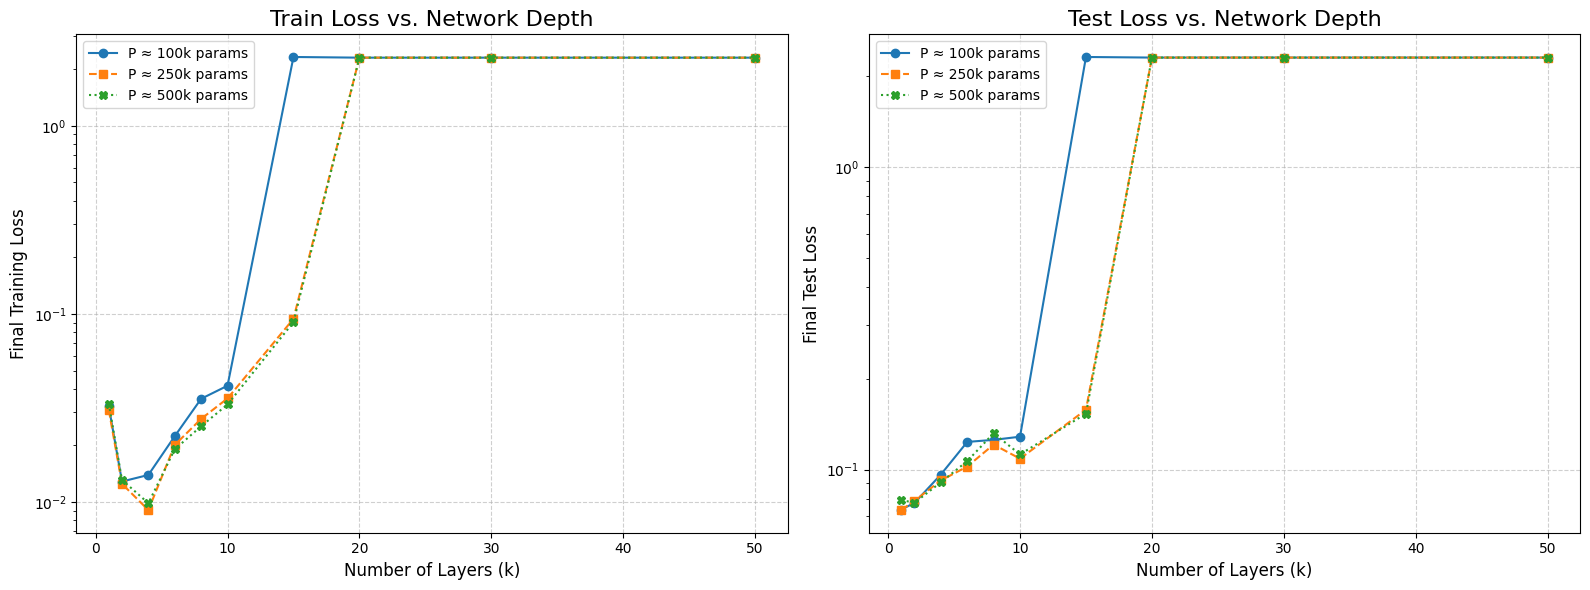

In [23]:
# Plot training and testing loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define styles for each line to make them unique
styles = {
    100000: {'marker': 'o', 'linestyle': '-', 'color': 'C0'}, # Circle, solid, blue
    250000: {'marker': 's', 'linestyle': '--', 'color': 'C1'}, # Square, dashed, orange
    500000: {'marker': 'X', 'linestyle': ':', 'color': 'C2'}  # X, dotted, green
}

# Plot 1: Training Loss
ax1.set_title('Train Loss vs. Network Depth', fontsize=16)
ax1.set_xlabel('Number of Layers (k)', fontsize=12)
ax1.set_ylabel('Final Training Loss', fontsize=12)

# Loop through each parameter budget (P) in the results
for P, data in all_results.items():
    style = styles[P]
    # Plot k vs training loss for the current P
    ax1.plot(data['k'], data['train_loss'], marker=style['marker'], linestyle=style['linestyle'], color=style['color'], label=f'P ≈ {P/1000:.0f}k params')

ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_yscale('log')

# Plot 2: Test Loss
ax2.set_title('Test Loss vs. Network Depth', fontsize=16)
ax2.set_xlabel('Number of Layers (k)', fontsize=12)
ax2.set_ylabel('Final Test Loss', fontsize=12)

# Loop through each parameter budget (P) in the results
for P, data in all_results.items():
    style = styles[P]
    # Plot k vs test loss for the current P
    ax2.plot(data['k'], data['test_loss'], marker=style['marker'], linestyle=style['linestyle'], color=style['color'], label=f'P ≈ {P/1000:.0f}k params')

ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

Now building and training the network with optimized k and m

In [28]:
fixed_network = FixedSizeNetwork(input_size=784, output_size=10, num_layers=1, hidden_width=314) # k = num_layers, m = hidden_width
fixed_train_loss = fixed_network.train(X_train, y_train, epochs=25, lr=0.1, batch_size=64)
fixed_test_loss, fixed_test_acc = fixed_network.test(X_test, y_test)

Epoch 1/25, Training Loss: 0.4490
Epoch 2/25, Training Loss: 0.2947
Epoch 3/25, Training Loss: 0.2451
Epoch 4/25, Training Loss: 0.2019
Epoch 5/25, Training Loss: 0.1694
Epoch 6/25, Training Loss: 0.1457
Epoch 7/25, Training Loss: 0.1277
Epoch 8/25, Training Loss: 0.1136
Epoch 9/25, Training Loss: 0.1021
Epoch 10/25, Training Loss: 0.0925
Epoch 11/25, Training Loss: 0.0843
Epoch 12/25, Training Loss: 0.0772
Epoch 13/25, Training Loss: 0.0711
Epoch 14/25, Training Loss: 0.0656
Epoch 15/25, Training Loss: 0.0608
Epoch 16/25, Training Loss: 0.0564
Epoch 17/25, Training Loss: 0.0525
Epoch 18/25, Training Loss: 0.0489
Epoch 19/25, Training Loss: 0.0457
Epoch 20/25, Training Loss: 0.0427
Epoch 21/25, Training Loss: 0.0400
Epoch 22/25, Training Loss: 0.0375
Epoch 23/25, Training Loss: 0.0351
Epoch 24/25, Training Loss: 0.0329
Epoch 25/25, Training Loss: 0.0309
Final Train Loss: 0.0309, Final Train Accuracy: 0.9896
Test Loss: 0.0780, Test Accuracy: 0.9753


# 3. Improving Architecture

In [29]:
class FlexibleSizeNetwork(BaseNetwork):
  def __init__(self, input_size=784, output_size=10, hidden_layers=[], device='cpu'):
    super().__init__(device=device)

    layers = []

    if hidden_layers:
      layers.append(nn.Linear(input_size, hidden_layers[0]))
      layers.append(nn.Tanh())

      for i in range(len(hidden_layers) - 1):
        layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
        layers.append(nn.Tanh())

      layers.append(nn.Linear(hidden_layers[-1], output_size))
    else:
      layers.append(nn.Linear(input_size, output_size))

    self.all_layers = nn.Sequential(*layers)
    self.to(self.device)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    return self.all_layers(x)

  # train() and test() are inherited from BaseNetwork